In [1]:
import librosa
import librosa.display
import os
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import random
import keras
import datetime as dt
import time

from keras import layers
from keras import models
from tensorflow.keras import optimizers

from keras.layers import *
from keras.models import *
from keras import initializers, regularizers, constraints
from keras.layers.normalization import BatchNormalization 
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_recall_fscore_support
from tensorflow.keras import backend as K

from ABNmodules_multiclass import *
from sklearn.metrics import f1_score

tf.set_random_seed(1004)
random.seed(1004)

os.environ["CUDA_VISIBLE_DEVICES"]="1"
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)


/usr/local/lib/python3.6/dist-packages/numba/errors.py:137: UserWarning: Insufficiently recent colorama version found. Numba requires colorama >= 0.3.9
  warnings.warn(msg)
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)typ

In [2]:
import sys
sys.version

'3.6.9 (default, Jul 17 2020, 12:50:27) \n[GCC 8.4.0]'

In [3]:

def score_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

def dot_product(x, kernel):
    if K.backend() == 'tensorflow':
        return K.squeeze(K.dot(x, K.expand_dims(kernel)), axis=-1)
    else:
        return K.dot(x, kernel)
    
def get_unique_classes(input_directory,files):

    unique_classes=set()
    for f in files:
        g = f.replace('.mat','.hea')
        input_file = os.path.join(input_directory,g)
        with open(input_file,'r') as f:
            for lines in f:
                if lines.startswith('#Dx'):
                    tmp = lines.split(': ')[1].split(',')
                    for c in tmp:
                        unique_classes.add(c.strip())
    return sorted(unique_classes)

def one_hot_encoding(one_hot_vector,y, class2index):
    ind=class2index[y]
    one_hot_vector[ind]=1
    return one_hot_vector

# Search for multi-label subjects
def searching_overlap(input_directory,class2index, input_file_names):
    multiclasses=[]
    multisubjects=[]
    number = []
    for file in input_file_names:
        f=file
        g = f.replace('.mat','.hea')
        input_file = os.path.join(input_directory,g)
        with open(input_file,'r') as f:
            for lines in f:
                if lines.startswith('#Dx'):
                    tmp = lines.split(': ')[1].split(',')
                    if len(tmp)>1:
                        one_hot_vector = [0]*(len(class2index))
                        for c in tmp:
                            one_hot_vector = one_hot_encoding(one_hot_vector, c.strip(), class2index)
                        multiclasses.append(one_hot_vector)
                        multisubjects.append(g)
                        number.append(len(tmp))
    return multisubjects, multiclasses, number

def block_feature(sequence_en, minimum_len): 
    new_en = []
    if len(sequence_en) > minimum_len:  # 길이가 minimum보다 긴 경우
        start = random.randint(0,len(sequence_en)-minimum_len)
        #print(start)
        new_en = sequence_en[start:start+minimum_len]
    elif len(sequence_en) == minimum_len: # 길이가 minimum
        new_en = sequence_en
    else: 
        assert len(sequence_en) <= minimum_len
    return new_en

def exploratory_look(input_directory,file, class2index):
    classes = []
    f = file
    g = f.replace('.mat','.hea')
    input_file = os.path.join(input_directory,g)
    with open(input_file,'r') as f:
        for lines in f:
            if lines.startswith('#Dx'):
                tmp = lines.split(': ')[1].split(',')
                print(tmp, len(tmp))
    return tmp     

# Get classes of sorted file names
def get_labels(input_directory,file, class2index):
    f = file
    g = f.replace('.mat','.hea')
    input_file = os.path.join(input_directory,g)
    with open(input_file,'r') as f:
        for lines in f:
            if lines.startswith('#Dx'):
                tmp = lines.split(': ')[1].split(',')
                one_hot_vector = [0]*(len(class2index))
                for c in tmp:
                    one_hot_vector = one_hot_encoding(one_hot_vector, c.strip(), class2index)
                
    return one_hot_vector

def randextract_mels(curr_step, batch_size, data, mel_directory, class2index, minimum_len, x_mean_final, x_std_final):
    mel_files = []
    classes = []
    start = batch_size*curr_step
    end = batch_size*(curr_step+1)
    curr_file_indices = data[start:end]
    for file in curr_file_indices:
        tmp_file = np.load(mel_directory + '/' + file.replace('.mat', '.npy'))
        clip_file = block_feature(tmp_file, minimum_len)
        clip_file -= x_mean_final
        clip_file /= x_std_final
        mel_files.append(clip_file)
        label = get_labels(input_directory, file, class2index)
        classes.append(label)
    
    concat = list(zip(mel_files, classes))
    random.shuffle(concat)
    mel_files, classes = zip(*concat)
    return mel_files, classes

def zeropadding_mels(curr_step, batch_size, data, mel_directory, class2index, minimum_len, x_mean_final, x_std_final):
    mel_files = []
    classes = []
    start = batch_size*curr_step
    end = batch_size*(curr_step+1)
    curr_file_indices = data[start:end]    
    for file in curr_file_indices:
        
        tmp_file = np.load(mel_directory + '/' + file.replace('.mat', '.npy'))
        tmp_file -= x_mean_final
        tmp_file /= x_std_final        
#         print(tmp_file.shape)
        zero_padding = np.zeros((minimum_len-len(tmp_file), 12))
#         print(zero_padding.shape)
        clip_file = np.concatenate((zero_padding, tmp_file), axis=0)
#         print(clip_file)
#         clip_file = zero_padding + tmp_file
#         print(clip_file.shape)
#         clip_file = block_feature(tmp_file, minimum_len)
        #print(clip_file.shape)
        #clip_file = tmp_file[:minimum_len]

        mel_files.append(clip_file)
        label = get_labels(input_directory, file, class2index)
        classes.append(label)
    concat = list(zip(mel_files, classes))
    random.shuffle(concat)
    mel_files, classes = zip(*concat)
    return mel_files, classes  

def train(data_train, mel_directory, batch_size, class2index, minimum_len, x_mean_final, x_std_final, model): 
    loss=[]
#     acc = []
    f1 = []

    total_steps = int(np.ceil(len(data_train)/batch_size))
    for curr_step in range(total_steps): # loops over batches
        batch_mels, batch_labels = randextract_mels(curr_step, batch_size, data_train, mel_directory, class2index, minimum_len, x_mean_final, x_std_final)
#         batch_mels, batch_labels = zeropadding_mels(curr_step, batch_size, data_train, mel_directory, class2index, minimum_len, x_mean_final, x_std_final)
        batch_mels = np.asarray(batch_mels)
        batch_labels = np.asarray(np.squeeze(batch_labels))
        
        batch_labels = [batch_labels, batch_labels]


# return of train
# 0 = total loss (attention branch + perception branch)
# 1 = loss of attention pred
# 2 = loss of perception pred
# 3 = f1 of attention pred
# 4 = f1 of perception pred     


        train_tmp = model.train_on_batch(batch_mels, batch_labels)
        loss_ = train_tmp[0]/2
        f1_ = np.mean((train_tmp[3], train_tmp[4]))
        loss.append(loss_)
        f1.append(f1_)

    loss = np.mean(np.array(loss))
    f1 = np.mean(np.array(f1))
    return loss, f1

def train_edit(data_train, mel_directory, batch_size, class2index, minimum_len, x_mean_final, x_std_final, model): 
    loss=[]
#     acc = []
    f1 = []

    total_steps = int(np.ceil(len(data_train)/batch_size))
    for curr_step in range(total_steps): # loops over batches
        batch_mels, batch_labels = randextract_mels(curr_step, batch_size, data_train, mel_directory, class2index, minimum_len, x_mean_final, x_std_final)

        batch_mels = np.asarray(batch_mels)
        batch_labels = np.asarray(np.squeeze(batch_labels))


        heatmap = CAM_conv1D(minimum_len, n_channels, batch_mels, batch_labels, out_len, get_conv_out)        
        heatmap = np.asarray(heatmap)
        
        batch_labels = [batch_labels, batch_labels]


# return of train
# 0 = total loss (attention branch + perception branch)
# 1 = loss of attention pred
# 2 = loss of perception pred
# 3 = f1 of attention pred
# 4 = f1 of perception pred     

        train_tmp = model.train_on_batch([batch_mels, heatmap], batch_labels)
        loss_ = train_tmp[0]/2
        f1_ = np.mean((train_tmp[3], train_tmp[4]))
        loss.append(loss_)
        f1.append(f1_)

    loss = np.mean(np.array(loss))
    f1 = np.mean(np.array(f1))
    return loss, f1

def test(data, mel_directory, input_directory, class2index, minimum_len, model, x_mean_final, x_std_final):
    scores = []
    predicted_labels=[]
    accuracy=np.zeros(len(data))
    total_acc = 0
    total_f1 = 0
    
    y_true = []
    y_pred=[]
    
    mel_files = []
    classes = []
    
    multi_files, _, _ = searching_overlap(input_directory,class2index, data)
    multi_acc = 0
    multi_y_true=[]
    multi_y_pred=[]    
    single_acc = 0
    single_y_true=[]
    single_y_pred=[]     
    
    for file in data:
        tmp_file = np.load(mel_directory + '/' + file.replace('.mat', '.npy'))
        steps = int(np.floor(tmp_file.shape[0]/minimum_len))
        mel_files = []
        heatmap_files=[]
        label = get_labels(input_directory, file, class2index)
        label = [label]
        for block in range(steps): # 128개씩 쪼갠 블럭 단위로 predict
            start = block*minimum_len
            end = (block+1)*minimum_len
            clip_file = tmp_file[start:end]
            clip_file -= x_mean_final
            clip_file /= x_std_final
            clip_file = clip_file.reshape(1,minimum_len,n_channels)
            mel_files.append(clip_file)    
        mel_files = np.asarray(mel_files)
        mel_files = mel_files.reshape(steps,minimum_len,n_channels)
        logit = model.predict(mel_files)
        logit = np.mean(logit, axis=0)
        logit = np.mean(logit, axis=0)
        pred = np.zeros(len(logit))
        for ii, label in enumerate(logit):
            if label >= 0.5:
                pred[ii] = 1
            else:
                pred[ii] = 0
        pred = pred.tolist()
        y_pred.append(pred)
        label = get_labels(input_directory,file,class2index)
        y_true.append(label)
        if pred == label:
            acc = 1
        else:
            acc = 0
        total_acc += acc
        if file.replace('.mat', '.hea') in multi_files:
            multi_y_true.append(label)            
            multi_y_pred.append(pred)
            multi_acc += acc
        else: # for calculating single_label accuracy
            single_y_true.append(label)            
            single_y_pred.append(pred)
            single_acc += acc            
        
    final_acc = total_acc / len(data)
    f1_classes = f1_score(y_true, y_pred, average=None)
    f1_micro = f1_score(y_true, y_pred, average='micro')
    
    multi_final_acc = multi_acc / len(multi_files)
    multi_f1_classes = f1_score(multi_y_true, multi_y_pred, average=None)
    multi_f1_micro = f1_score(multi_y_true, multi_y_pred, average='micro')

    single_final_acc = single_acc / (len (data) - len(multi_files))
    single_f1_classes = f1_score(single_y_true, single_y_pred, average=None)
    single_f1_micro = f1_score(single_y_true, single_y_pred, average='micro')    
    
    return final_acc, f1_classes, f1_micro, multi_final_acc, multi_f1_classes, multi_f1_micro, single_final_acc, single_f1_classes, single_f1_micro

def test_zero(data, mel_directory, input_directory, class2index, minimum_len, model, x_mean_final, x_std_final):
    scores = []
    predicted_labels=[]
    accuracy=np.zeros(len(data))
    #total_loss=[]
    total_acc = 0
    total_f1 = 0
    y_true = []
    y_pred=[]    
    mel_files = []
    classes = []
    
    
    multi_files, _, _ = searching_overlap(input_directory,class2index, data)
    multi_acc = 0
    multi_y_true=[]
    multi_y_pred=[]    
    single_acc = 0
    single_y_true=[]
    single_y_pred=[]  
    for file in data:
        tmp_file = np.load(mel_directory + '/' + file.replace('.mat', '.npy'))
        tmp_file -= x_mean_final
        tmp_file /= x_std_final
        steps = int(np.floor(tmp_file.shape[0]/minimum_len))
        mel_files = []
#         for block in range(steps): # 128개씩 쪼갠 블럭 단위로 predict
            
        zero_padding = np.zeros((minimum_len-len(tmp_file), 12))
        clip_file = np.concatenate((zero_padding, tmp_file), axis=0)
#         print(clip_file.shape)
        

        mel_files.append(clip_file)
        mel_files = np.asarray(mel_files)
        logit = model.predict(mel_files)
        logit = np.mean(logit, axis=0)
        logit = np.mean(logit, axis=0)        
        
        
        pred = np.zeros(len(logit))
        for ii, label in enumerate(logit):
            if label >= 0.5:
                pred[ii] = 1
            else:
                pred[ii] = 0
        pred = pred.tolist()
        y_pred.append(pred)        
        label = get_labels(input_directory,file,class2index)
        y_true.append(label)
        
        if pred == label:
            acc = 1
        else:
            acc = 0
        total_acc += acc
        if file.replace('.mat', '.hea') in multi_files:
            multi_y_true.append(label)            
            multi_y_pred.append(pred)
            multi_acc += acc         
        else: # for calculating single_label accuracy
            single_y_true.append(label)            
            single_y_pred.append(pred)
            single_acc += acc         
        #total_f1 += f1
    final_acc = total_acc / len(data)
    f1_classes = f1_score(y_true, y_pred, average=None)
    f1_micro = f1_score(y_true, y_pred, average='micro')
    
    multi_final_acc = multi_acc / len(multi_files)
    multi_f1_classes = f1_score(multi_y_true, multi_y_pred, average=None)
    multi_f1_micro = f1_score(multi_y_true, multi_y_pred, average='micro')
    
    single_final_acc = single_acc / (len (data) - len(multi_files))
    single_f1_classes = f1_score(single_y_true, single_y_pred, average=None)
    single_f1_micro = f1_score(single_y_true, single_y_pred, average='micro')    
    
    return final_acc, f1_classes, f1_micro, multi_final_acc, multi_f1_classes, multi_f1_micro, single_final_acc, single_f1_classes, single_f1_micro


def test_edit(data, mel_directory, input_directory, class2index, minimum_len, model, x_mean_final, x_std_final):
    scores = []
    predicted_labels=[]
    accuracy=np.zeros(len(data))
    #total_loss=[]
    total_acc = 0
    total_f1 = 0
    
    y_true = []
    y_pred = []
    
    mel_files = []
    classes = []
    
    multi_files, _, _ = searching_overlap(input_directory,class2index, data)
    multi_acc = 0
    multi_y_true=[]
    multi_y_pred=[]    
    
    for file in data:
        tmp_file = np.load(mel_directory + '/' + file.replace('.mat', '.npy'))
        steps = int(np.floor(tmp_file.shape[0]/minimum_len))
        mel_files = []
        heatmap_files=[]
        label = get_labels(input_directory, file, class2index)
        label = [label]
        for block in range(steps): # 128개씩 쪼갠 블럭 단위로 predict
            start = block*minimum_len
            end = (block+1)*minimum_len
            clip_file = tmp_file[start:end]
            clip_file -= x_mean_final
            clip_file /= x_std_final
            clip_file = clip_file.reshape(1,minimum_len,n_channels)
            heatmap = CAM_conv1D(minimum_len, n_channels, clip_file, label, out_len, get_conv_out)
            mel_files.append(clip_file)    
            heatmap_files.append(heatmap)
        mel_files = np.asarray(mel_files)
        heatmap_files = np.asarray(heatmap_files)
        heatmap_files = heatmap_files.reshape(steps, out_len,1)
        mel_files = mel_files.reshape(steps,minimum_len,n_channels)
        logit = model.predict([mel_files, heatmap_files])
        logit = np.mean(logit, axis=0)
        logit = np.mean(logit, axis=0)
        pred = np.zeros(len(logit))
        for ii, label in enumerate(logit):
            if label >= 0.5:
                pred[ii] = 1
            else:
                pred[ii] = 0
        pred = pred.tolist()
        y_pred.append(pred)
        label = get_labels(input_directory,file,class2index)
        y_true.append(label)
        if pred == label:
            acc = 1
        else:
            acc = 0
        total_acc += acc
        if file.replace('.mat', '.hea') in multi_files:
            multi_y_true.append(label)
            multi_y_pred.append(pred)
            multi_acc += acc               
    final_acc = total_acc / len(data)
    f1_classes = f1_score(y_true, y_pred, average=None)
    f1_micro = f1_score(y_true, y_pred, average='micro')
    
    multi_final_acc = multi_acc / len(multi_files)
    multi_f1_classes = f1_score(multi_y_true, multi_y_pred, average=None)
    multi_f1_micro = f1_score(multi_y_true, multi_y_pred, average='micro')
    
    return final_acc, f1_classes, f1_micro, multi_final_acc, multi_f1_classes, multi_f1_micro

def test_edit_final(data, mel_directory, input_directory, class2index, minimum_len, model, x_mean_final, x_std_final, p_model):
    scores = []
    predicted_labels=[]
    accuracy=np.zeros(len(data))
    #total_loss=[]
    total_acc = 0
    total_f1 = 0
    
    y_true = []
    y_pred=[]
    
    
    mel_files = []
    classes = []
    
    multi_files, _, _ = searching_overlap(input_directory,class2index, data)
    multi_acc = 0
    multi_y_true=[]
    multi_y_pred=[]
    
    for file in data:
        tmp_file = np.load(mel_directory + '/' + file.replace('.mat', '.npy'))
        steps = int(np.floor(tmp_file.shape[0]/minimum_len))
        mel_files = []
        mel_files_logit = []
        heatmap_files=[]

        for block in range(steps): # 128개씩 쪼갠 블럭 단위로 predict
            start = block*minimum_len
            end = (block+1)*minimum_len
            clip_file = tmp_file[start:end]
            clip_file -= x_mean_final
            clip_file /= x_std_final
            clip_file = clip_file.reshape(1,minimum_len,n_channels)
            
            # 여기서 logit으로 y구함#####################
            logit_ = p_model.predict(clip_file)
            logit_ = np.mean(logit_, axis=0)
            logit_ = np.mean(logit_, axis=0)
            pred_ = np.zeros(len(logit_))
            for ii, label in enumerate(logit_):
                if label >= 0.5: 
                    pred_[ii] = 1
                else:
                    pred_[ii] = 0
            pred_ = pred_.tolist()
            ##########################################
            
            heatmap = CAM_conv1D(minimum_len, n_channels, clip_file, [pred_], out_len, get_conv_out)
            mel_files.append(clip_file)    
            heatmap_files.append(heatmap)
        mel_files = np.asarray(mel_files)
        heatmap_files = np.asarray(heatmap_files)
        heatmap_files = heatmap_files.reshape(steps, out_len,1)
        mel_files = mel_files.reshape(steps,minimum_len,n_channels)
        logit = model.predict([mel_files, heatmap_files])
        logit = np.mean(logit, axis=0)
        logit = np.mean(logit, axis=0)
        pred = np.zeros(len(logit))
        for ii, label in enumerate(logit):
            if label >= 0.5:
                pred[ii] = 1
            else:
                pred[ii] = 0
        pred = pred.tolist()
        y_pred.append(pred)
        label = get_labels(input_directory,file,class2index)
        y_true.append(label)
        if pred == label:
            acc = 1
        else:
            acc = 0
        total_acc += acc
        if file.replace('.mat', '.hea') in multi_files:
            multi_y_true.append(label)          
            multi_y_pred.append(pred)
            multi_acc += acc       

    final_acc = total_acc / len(data)
    f1_classes = f1_score(y_true, y_pred, average=None)
    f1_micro = f1_score(y_true, y_pred, average='micro')
    
    multi_final_acc = multi_acc / len(multi_files)
    multi_f1_classes = f1_score(multi_y_true, multi_y_pred, average=None)
    multi_f1_micro = f1_score(multi_y_true, multi_y_pred, average='micro')
    
    return final_acc, f1_classes, f1_micro, multi_final_acc, multi_f1_classes, multi_f1_micro

def test_edit_final2(data, mel_directory, input_directory, class2index, minimum_len, model, x_mean_final, x_std_final, p_model):
    scores = []
    predicted_labels=[]
    accuracy=np.zeros(len(data))
    #total_loss=[]
    total_acc = 0
    total_f1 = 0
    
    mel_files = []
    classes = []
    
    y_true = []
    y_pred=[]    

    multi_files, _, _ = searching_overlap(input_directory,class2index, data)
    multi_acc = 0
    multi_y_true=[]
    multi_y_pred=[]    
    
    for file in data:
        tmp_file = np.load(mel_directory + '/' + file.replace('.mat', '.npy'))
        steps = int(np.floor(tmp_file.shape[0]/minimum_len))
        mel_files = []
        mel_files_logit = []
        heatmap_files=[]

        for block in range(steps):
            # 여기서 logit으로 y구함
            start = block*minimum_len
            end = (block+1)*minimum_len
            clip_file = tmp_file[start:end]
            clip_file -= x_mean_final
            clip_file /= x_std_final
            clip_file = clip_file.reshape(1,minimum_len,n_channels)
            mel_files_logit.append(clip_file)
            
        mel_files_logit = np.asarray(mel_files_logit)
        mel_files_logit = mel_files_logit.reshape(steps,minimum_len,n_channels)
        
        
        
        logit_ = p_model.predict(mel_files_logit)
        
        logit_ = np.mean(logit_, axis=0)
        logit_ = np.mean(logit_, axis=0)
#         print(logit_)
        pred_ = np.zeros(len(logit_))
        for ii, label in enumerate(logit_):
            if label >= 0.5: 
                pred_[ii] = 1
            else:
                pred_[ii] = 0
        
        pred_ = pred_.tolist()

#         print(pred_)
            #######
        
        
        for block in range(steps): # 128개씩 쪼갠 블럭 단위로 predict
            start = block*minimum_len
            end = (block+1)*minimum_len
            clip_file = tmp_file[start:end]
            clip_file -= x_mean_final
            clip_file /= x_std_final
            clip_file = clip_file.reshape(1,minimum_len,n_channels)

            heatmap = CAM_conv1D(minimum_len, n_channels, clip_file, [pred_], out_len, get_conv_out)
#             print(heatmap)
            mel_files.append(clip_file)    
            heatmap_files.append(heatmap)
        mel_files = np.asarray(mel_files)
        heatmap_files = np.asarray(heatmap_files)
        heatmap_files = heatmap_files.reshape(steps, out_len,1)
        mel_files = mel_files.reshape(steps,minimum_len,n_channels)
        logit = model.predict([mel_files, heatmap_files])
        logit = np.mean(logit, axis=0)
        logit = np.mean(logit, axis=0)
        pred = np.zeros(len(logit))
       

        for ii, label in enumerate(logit):
            if label >= 0.5:
                pred[ii] = 1
            else:
                pred[ii] = 0
        pred = pred.tolist()
        y_pred.append(pred)
#         print(pred)
        label = get_labels(input_directory,file,class2index)
        y_true.append(label)
#         print(label)
        if pred == label:
            acc = 1
        else:
            acc = 0
        total_acc += acc
        if file.replace('.mat', '.hea') in multi_files:
            multi_y_true.append(label)
            multi_y_pred.append(pred)
            multi_acc += acc       

    final_acc = total_acc / len(data)
    f1_classes = f1_score(y_true, y_pred, average=None)
    f1_micro = f1_score(y_true, y_pred, average='micro')
    
    multi_final_acc = multi_acc / len(multi_files)
    multi_f1_classes = f1_score(multi_y_true, multi_y_pred, average=None)
    multi_f1_micro = f1_score(multi_y_true, multi_y_pred, average='micro')
    
    return final_acc, f1_classes, f1_micro, multi_final_acc, multi_f1_classes, multi_f1_micro

batch_size = 32
minimum_len = 2880 #72000 #2880
epochs = 1000#300#1000
n_channels=12
loss_function = 'binary_crossentropy' 
rootdir = '../'
date = dt.datetime.today().strftime("%Y%m%d")
input_directory = os.path.join(rootdir, 'Training_WFDB')
mel_name = 'Raw_data_20200424' 
mel_directory = os.path.join(rootdir, mel_name)
# results_directory = os.path.join(rootdir, 'results_'+date+'_0_IEEE_n=1')
# results_directory = os.path.join(rootdir, 'results_'+date+'_editting_CAM_multiclass')

if not os.path.isdir(input_directory):
    os.mkdir(input_directory)
if not os.path.isdir(mel_directory):
    os.mkdir(mel_directory)

        
input_files = []
for f in os.listdir(input_directory):
    if os.path.isfile(os.path.join(input_directory, f)) and not f.lower().startswith('.') and f.lower().endswith('mat'):
        input_files.append(f)
input_file_names = sorted(input_files)

unique_classes = get_unique_classes(input_directory, input_files)
class2index = {}
for a, b in enumerate(unique_classes):
    class2index[b] = a

np.shape(input_file_names)

x_mean_all = []
x_std_all = []
for file in input_file_names:
    x = np.load(mel_directory + '/' + file.replace('.mat', '.npy'))
    x_mean = [np.mean(x[:,0]), np.mean(x[:,1]), np.mean(x[:,2]), np.mean(x[:,3]), np.mean(x[:,4]), np.mean(x[:,5]),
             np.mean(x[:,6]), np.mean(x[:,7]), np.mean(x[:,8]), np.mean(x[:,9]), np.mean(x[:,10]), np.mean(x[:,11])]
    
    x_std = [np.std(x[:,0]), np.std(x[:,1]), np.std(x[:,2]), np.std(x[:,3]), np.std(x[:,4]), np.std(x[:,5]),
             np.std(x[:,6]), np.std(x[:,7]), np.std(x[:,8]), np.std(x[:,9]), np.std(x[:,10]), np.std(x[:,11])]
    x_mean_all.append(x_mean)
    x_std_all.append(x_std) # yjs corrected on 2020-05-25
x_mean_final = np.mean(x_mean_all, axis=0)
x_std_final = np.mean(x_std_all, axis=0)


data, data_test = train_test_split(input_file_names, test_size = 0.2, train_size = 0.8, shuffle=True, random_state=1004)
data_train, data_val = train_test_split(data, test_size = 0.05, train_size = 0.95, shuffle=True, random_state=1004)
print(np.shape(data_train), np.shape(data_val), np.shape(data_test))

main_input = Input(shape=(minimum_len,12), dtype='float32', name='main_input')

(5225,) (276,) (1376,)


In [ ]:
data_train # starts with A2355

In [ ]:
data_val # starts with A5949

In [ ]:
data_test # starts with A0349

### Checking how many multilabel in each dataset

In [ ]:
# multi_train, _, _ = searching_overlap(input_directory, class2index, data_train)
# multi_val, _, _ = searching_overlap(input_directory, class2index, data_val)
# multi_test, _, _ = searching_overlap(input_directory, class2index, data_test)
# print(len(multi_train))
# print(len(multi_val))
# print(len(multi_test))

### For attention editting using CAM extracted from primitive ABN

In [ ]:
# # CAMdir = '/home/taejoon/PhysioNetChallenge/results_20200622_ABN_multiclass_V4_primitiveABN'
# CAMdir = '/home/taejoon/PhysioNetChallenge/results_20200625_V4_ABN_primitive_n=1'
# p_model = primitive_ABN((None, 12), 9, minimum_len, out_ch=256, n=1)
# latest = tf.train.latest_checkpoint(CAMdir)
# p_model.load_weights(latest)

# conv_layer = 'activation_5'
# softmax_layer = 'perception_branch_dense_2'


# out_len=12
# get_conv_out = K.function(p_model.input, [p_model.get_layer(conv_layer).output, p_model.get_layer(softmax_layer).weights[0]])

# def CAM_conv1D(minimum_len, n_channels, x, y, out_len, get_conv_out):
    
#     # x랑 y는 batch size만큼의 리스트 (32)
#     heatmaps=[]    
    
#     curr_x = np.asarray(x)
#     curr_x = curr_x.reshape(len(x),minimum_len,n_channels)
    
#     conv_out, softmax_weights = get_conv_out(curr_x)

#     for i in range(len(x)):

#         curr_classes = y[i]
#         class_index=[]
#         [class_index.append(j) for j in range(len(curr_classes)) if curr_classes[j]==1]
#         heatmap = np.zeros((1,12)) #heatmap=np.zeros((1,36)) # might need to fix this if GradCAM or primitive model changes

#         conv_out_ = conv_out[i] # (36, 128) / (32, 12, 256)
# #         print(conv_out.shape)

#         for label in class_index:  # multiclass일 경우 대비해서 for문
#             curr_weights = softmax_weights[:,label]
#             weighted_conv = conv_out_*curr_weights
            
#             weighted_conv = weighted_conv.sum(axis=-1) # output = (1,36)
#             heatmap += weighted_conv
            
#         heatmap %= len(class_index) # 단일 class일 경우 1로 나눠짐. 두개일 경우 더해진 heatmap들이 2로 나눠짐
# #         heatmap = np.resize(heatmap, (1,out_len))
#         heatmap = np.resize(heatmap, (out_len, 1))
#         heatmaps.append(heatmap)
        
#     return heatmaps
# p_model.summary()

In [ ]:
# results_directory = os.path.join(rootdir, 'results_'+date+'_V5_ABN_primitive_leakyRELU_dropout_ver4')

# gamma = 0.0001 # 0.001


# model = ABN_model((None,12), len(unique_classes), minimum_len, n=1)
# model = primitive_ABN((None,12), len(unique_classes), minimum_len, n=1)
# model = edit_ABN_model((None,12), len(unique_classes), minimum_len,n=1)
# model, edit_loss = edit_ABN_model_loss((None,12), len(unique_classes), minimum_len,n=1, gamma = gamma)



# model.compile(loss=edit_loss,
#               optimizer=optimizers.Adam(lr=1e-5),           
#               metrics=[score_f1])


In [ ]:
# # 중단된 training 이어돌리기위해 임시로 사용
# results_directory = results_directory.replace("0608", "0604") # 날짜 달라졌을때
# latest = tf.train.latest_checkpoint(results_directory)
# latest
# model.load_weights(latest)

### Train

In [ ]:
# DISP DATETIME FOR CHECKING TIME
print(dt.datetime.now())





patience = 50
# gammas = [0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009]#[0.01, 0.1, 1, 10, 100] # finished: 0, 0.001, 
gammas = [0, 0.01, 0.1, 1, 10]
# gammas = [0.001]
for gamma in gammas:
    train_loss_sum=[]
    train_f1_sum=[]
    val_acc_sum=[]
    val_f1_sum=[]
    val_f1_classes=[]
    val_f1_min = 0
    results_directory = os.path.join(rootdir, 'results_'+date+'_e2e_ABN_zero_gamma' + str(gamma))
    print(results_directory)
    if not os.path.isdir(results_directory):
        os.mkdir(results_directory)
    model, edit_loss = endtoend_edit_ABN_model_loss((None,12), len(unique_classes), minimum_len,n=1, gamma = gamma)
    model.compile(loss=loss_function,
              optimizer=optimizers.Adam(lr=1e-5),           
              metrics=[score_f1])
    model.summary()
    for num_epoch in range(epochs):
    #     num_epoch += 32 # 중단된 코드 돌리기 위해 임의로 사용
        random.shuffle(data_train)
        train_loss, train_f1 = train(data_train, mel_directory, batch_size, class2index, minimum_len, x_mean_final, x_std_final, model)
    #     train_loss, train_f1 = train_edit(data_train, mel_directory, batch_size, class2index, minimum_len, x_mean_final, x_std_final, model)

        train_loss_sum.append(train_loss)
        train_f1_sum.append(train_f1)

        print('\nEpoch',num_epoch,'train_loss:',f'{train_loss:.3f}','train_f1:',f'{train_f1:.3f}',"\t")
        model_output = "ECG_ABN_E%02dL%.2f" % (num_epoch, train_loss)
        save_name = os.path.join(results_directory, model_output)

        val_acc, f1_classes, f1,_,_,_,_,_,_ = test(data_val, mel_directory, input_directory, class2index, minimum_len, model, x_mean_final, x_std_final)
    #     val_acc, f1_classes, f1,_,_,_ = test_edit(data_val, mel_directory, input_directory, class2index, minimum_len, model, x_mean_final, x_std_final)
#         val_acc, f1_classes, f1,_,_,_,_,_,_ = test_zero(data_val, mel_directory, input_directory, class2index, minimum_len, model, x_mean_final, x_std_final)    


        val_acc_sum.append(val_acc)
        val_f1_sum.append(f1)
        val_f1_classes.append(f1_classes)

        if f1 > val_f1_min:
            val_f1_min = f1
            earlystop = 0
            if val_acc > 0.6: # 너무 낮아서 어차피 안쓸것들은 제외하기 위한 것
                model.save_weights(save_name.format(epoch=0))
        else: 
            earlystop += 1
            if earlystop > patience: 
                print("Early stopped training due to non-improved performance")
                break

        print('\nValidation', num_epoch, 'valid_f1:',f'{f1:.3f}', 'best_f1:',f'{val_f1_min:.3f}', 'mean accuracy:' f'{val_acc:.3f}',"\t")
    #     print('\nValidation mean accuracy: ', f'{val_acc:.3f}', "\t")
    #     print('\nValidation mean f1 by classes: ',f1_classes, "\t")

    np.save(os.path.join(results_directory, 'train_loss_sum'), train_loss_sum)
    np.save(os.path.join(results_directory, 'train_f1_sum'), train_f1_sum)
    np.save(os.path.join(results_directory, 'val_acc_sum'), val_acc_sum)
    np.save(os.path.join(results_directory, 'val_f1_sum'), val_f1_sum)
    np.save(os.path.join(results_directory, 'val_f1_classes'), val_f1_classes)
    del model
    del edit_loss
    print(dt.datetime.now())

### Test

In [4]:
results_directory

NameError: name 'results_directory' is not defined

In [47]:
# gammas = [0, 0.001, 0.01, 0.1, 1, 10]
gammas = [0.001, 0.01, 0.1, 1, 10]

In [49]:
# del test_model
F1s_ = []
Accs_ = []
minimum_len = 2880
for gamma in gammas: 
#     results_directory = os.path.join(rootdir, 'results_20200825_e2e_ABN_zero_gamma' + str(gamma))
    results_directory = os.path.join(rootdir, 'results_2020082X_e2e_ABN_zero_gamma' + str(gamma))
    test_model,_ = endtoend_edit_ABN_model_loss((None,12), len(unique_classes), minimum_len,n=1, gamma = gamma)  
    latest_test = tf.train.latest_checkpoint(results_directory)
    test_model.load_weights(latest_test)    
#     test_acc, f1_classes, f1,m_acc, m_f1, m_sum, s_acc, s_f1, s_sum = test_zero(data_val, mel_directory, input_directory, class2index, minimum_len, test_model, x_mean_final, x_std_final)
    test_acc, f1_classes, f1,m_acc, m_f1, m_sum, s_acc, s_f1, s_sum = test(data_test, mel_directory, input_directory, class2index, minimum_len, test_model, x_mean_final, x_std_final)    
    print("Gamma = {}".format(gamma))
    print(np.round(test_acc,3))
#     print(f1_classes)
    print(np.round(f1,3))
    F1s_.append(f1)
    Accs_.append(test_acc)
#     print(m_acc)
#     print(m_f1)
#     print(m_sum)
#     print(s_acc)
#     print(s_f1)
#     print(s_sum)
    del test_model

Gamma = 0.001
0.717
0.797


Gamma = 0.01
0.717
0.798
Gamma = 0.1
0.715
0.794
Gamma = 1
0.725
0.8
Gamma = 10
0.72
0.798


In [50]:
F1s_


[0.7967988865692415,
 0.798313422347154,
 0.7940669196274579,
 0.8004094165813717,
 0.7984895296944731]

In [51]:
Accs_

[0.717296511627907,
 0.717296511627907,
 0.7151162790697675,
 0.7245639534883721,
 0.720203488372093]

In [76]:
# del test_model
F1s = []
Accs = []
minimum_len=72000
gammas = [0.01]
for gamma in gammas: 
#     results_directory = os.path.join(rootdir, 'results_20200825_e2e_ABN_zero_gamma' + str(gamma))
    results_directory = os.path.join(rootdir, 'results_2020072X_e2e_ABN_zero_gamma' + str(gamma))
    test_model,_ = endtoend_edit_ABN_model_loss((None,12), len(unique_classes), minimum_len,n=1, gamma = gamma)  
    latest_test = tf.train.latest_checkpoint(results_directory)
    test_model.load_weights(latest_test)    
    test_acc, f1_classes, f1,m_acc, m_f1, m_sum, s_acc, s_f1, s_sum = test_zero(data_test, mel_directory, input_directory, class2index, minimum_len, test_model, x_mean_final, x_std_final)
#     test_acc, f1_classes, f1,m_acc, m_f1, m_sum, s_acc, s_f1, s_sum = test(data_test, mel_directory, input_directory, class2index, minimum_len, test_model, x_mean_final, x_std_final)    
    print("Gamma = {}".format(gamma))
    print(np.round(test_acc,3))
#     print(f1_classes)
    print(np.round(f1,3))
    F1s.append(f1)
    Accs.append(test_acc)
#     print(m_acc)
#     print(m_f1)
#     print(m_sum)
#     print(s_acc)
#     print(s_f1)
#     print(s_sum)
    del test_model

Gamma = 0.01
0.726
0.812


In [77]:
class2index

{'AF': 0,
 'I-AVB': 1,
 'LBBB': 2,
 'Normal': 3,
 'PAC': 4,
 'PVC': 5,
 'RBBB': 6,
 'STD': 7,
 'STE': 8}

In [83]:
np.round(f1_classes,3)

array([0.92 , 0.892, 0.896, 0.749, 0.421, 0.672, 0.916, 0.751, 0.517])

In [79]:
f1

0.811718470882458

In [80]:
np.round(m_acc,3)

0.846

In [81]:
np.round(s_acc,3)

0.718

In [84]:
# del test_model
F1s = []
Accs = []
minimum_len=72000
gammas = [0]
for gamma in gammas: 
#     results_directory = os.path.join(rootdir, 'results_20200825_e2e_ABN_zero_gamma' + str(gamma))
    results_directory = os.path.join(rootdir, 'results_2020072X_e2e_ABN_zero_gamma' + str(gamma))
    test_model,_ = endtoend_edit_ABN_model_loss((None,12), len(unique_classes), minimum_len,n=1, gamma = gamma)  
    latest_test = tf.train.latest_checkpoint(results_directory)
    test_model.load_weights(latest_test)    
    test_acc, f1_classes, f1,m_acc, m_f1, m_sum, s_acc, s_f1, s_sum = test_zero(data_test, mel_directory, input_directory, class2index, minimum_len, test_model, x_mean_final, x_std_final)
#     test_acc, f1_classes, f1,m_acc, m_f1, m_sum, s_acc, s_f1, s_sum = test(data_test, mel_directory, input_directory, class2index, minimum_len, test_model, x_mean_final, x_std_final)    
    print("Gamma = {}".format(gamma))
    print(np.round(test_acc,3))
#     print(f1_classes)
    print(np.round(f1,3))
    F1s.append(f1)
    Accs.append(test_acc)
#     print(m_acc)
#     print(m_f1)
#     print(m_sum)
#     print(s_acc)
#     print(s_f1)
#     print(s_sum)
    del test_model

Gamma = 0
0.719
0.802


In [85]:
class2index

{'AF': 0,
 'I-AVB': 1,
 'LBBB': 2,
 'Normal': 3,
 'PAC': 4,
 'PVC': 5,
 'RBBB': 6,
 'STD': 7,
 'STE': 8}

In [86]:
np.round(f1_classes,3)

array([0.911, 0.885, 0.87 , 0.749, 0.357, 0.662, 0.921, 0.734, 0.453])

In [87]:
f1

0.8022638839759463

In [88]:
np.round(m_acc,3)

0.758

In [89]:
np.round(s_acc,3)

0.717

In [40]:
np.round(F1s,3)

array([0.802, 0.81 , 0.812, 0.778, 0.799, 0.796])

In [43]:
F1s

[0.8102240896358543,
 0.811718470882458,
 0.7776544580096189,
 0.7989949748743719,
 0.7958303378864126]

In [41]:
F1s_= F1s.remove(F1s[0])
F1s_
# F1s_ = np.round(F1s, 3)
# F1s_

In [42]:
F1s_

In [26]:
Accs

[0.7194767441860465,
 0.7340116279069767,
 0.7260174418604651,
 0.6649709302325582,
 0.7180232558139535,
 0.6940406976744186]

In [ ]:
# gamma = 0.0001
# test_model = ABN_model((None,12), len(unique_classes), minimum_len, n=1)
# test_model = primitive_ABN((None,12), len(unique_classes), minimum_len, n=1)
# test_model = edit_ABN_model((None,12), len(unique_classes), minimum_len, n=1)
# test_model, _ = edit_ABN_model_loss((None,12), len(unique_classes), minimum_len,n=1, gamma = gamma)
test_model,_ = endtoend_edit_ABN_model_loss((None,12), len(unique_classes), minimum_len,n=1, gamma = gamma)

# results_directory = os.path.join(rootdir, 'results_20200626_V4_ABN_primitive_editL1_gamma0.0001_primitive_updated')
# results_directory = os.path.join(rootdir, 'results_20200622_ABN_multiclass_V4_ABN')
# results_directory = os.path.join(rootdir, 'results_20200622_ABN_multiclass_V4_ABN_edit')
# results_directory = os.path.join(rootdir, 'results_'+date+'_ABN_primitive_n=7')
# results_directory = os.path.join(rootdir, 'results_20200626_V4_ABN_primitive_editL2_gamma0.0001_primitive_updated')
# results_directory = os.path.join(rootdir, 'results_20200709_ABN_dense512')
# test_model =  Model(inputs=main_input, outputs=main_output)
# test_model.load_weights(os.path.join(results_directory, 'ecg_mel_E829L0.17'))
# results_directory = os.path.join(rootdir, 'results_20200624_V4_ABN_edit_loss')


# test_model.load_weights(os.path.join(results_directory, 'ECG_ABN_E227L0.04'))
# results_directory = os.path.join(rootdir, 'results_20200724_e2e_ABN_zero_gamma0.01')
latest_test = tf.train.latest_checkpoint(results_directory)
test_model.load_weights(latest_test)
# test_model.load_weights(os.path.join(results_directory, 'ECG_ABN_E220L0.32'))
# test_model.summary()

In [ ]:
# gamma = 0.001
# results_directory = os.path.join(rootdir, 'results_'+date+'_e2e_ABN_zero_gamma' + str(gamma))

In [ ]:
test_acc, f1_classes, f1, m_acc, m_f1, m_sum, s_acc, s_f1, s_sum = test(data_test, mel_directory, input_directory, class2index, minimum_len, test_model, x_mean_final, x_std_final)
# test_acc, f1_classes, f1, m_acc, m_f1, m_sum, s_acc, s_f1, s_sum = test_edit_final(data_test, mel_directory, input_directory, class2index, minimum_len, test_model, x_mean_final, x_std_final, p_model)
# test_acc, f1_classes, f1,m_acc, m_f1, m_sum, s_acc, s_f1, s_sum = test_zero(data_val, mel_directory, input_directory, class2index, minimum_len, test_model, x_mean_final, x_std_final)

In [ ]:
latest_test

In [ ]:
np.round(test_acc, 3)

In [ ]:
f1_classes.round(3)

In [ ]:
class2index

In [ ]:
f1.round(3)

In [ ]:
np.round(m_acc, 3)

In [ ]:
m_f1.round(3)

In [ ]:
m_sum.round(3)

In [ ]:
np.round(s_acc, 3)

In [ ]:
s_f1.round(3)

In [ ]:
s_sum.round(3)

In [ ]:
# results_directory=os.path.join(rootdir, 'results_20200720_just_ABN_zero')

In [ ]:
gammas = [0.001, 0.01, 0.1, 1, 10] # finished: 0, 0.001, 

In [ ]:
np.log10(0.001)

In [ ]:
F1s

In [ ]:
Accs

In [ ]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

In [45]:
gammas = [0.001, 0.01, 0.1, 1, 10]

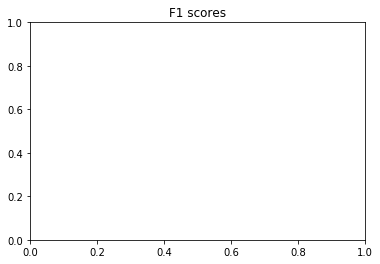

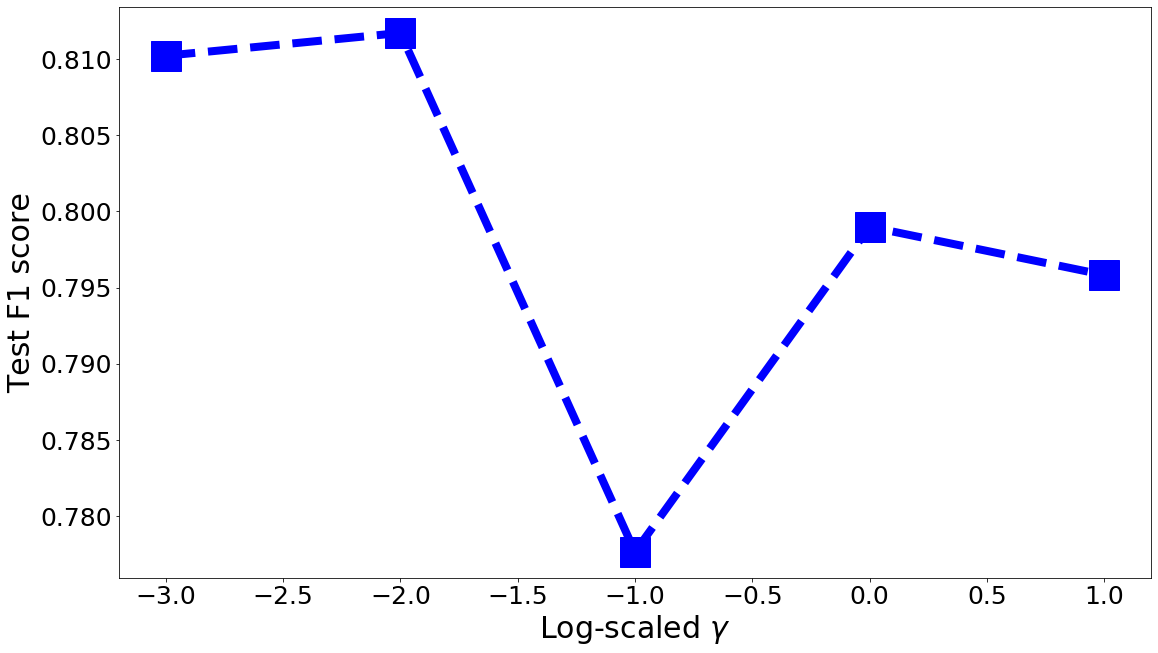

In [46]:
plt.title("F1 scores")
plt.figure(figsize=(18.5, 10.5))
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.xlabel("Log-scaled $\gamma$", fontsize=30)
plt.ylabel("Test F1 score", fontsize=30)
plt.plot(np.log10(gammas),F1s, 'bs--', markersize=30, linewidth=8)

In [ ]:
plt.gcf()set_size_inches(18.5, 10.5)

In [ ]:
3*2*8

In [ ]:
200/48